In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys

# Modifier la variable du TD en fonction de l'endroit où les données sont stockées
TD_DIR = 'gdrive/My Drive/ROB313/'
sys.path.append(TD_DIR)

Mounted at /content/gdrive


# Exercise 1

Q1.It's a linear neural network. At first, il define the input dimension and output dimension and randomly initilaize the weight parameter. Then it forward its calculation and generate its output par matrix mutiplication and relu function. After that, it compares its output and its target and compute gradients of w1 and w2 with respect to loss. Next it updates the weight w1 and w2. Finally, it iterates to have the best weight. 

In [ ]:
# -*- coding: utf-8 -*-

import torch


dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# Randomly initialize weights
w1 = torch.randn(D_in, H, device=device, dtype=dtype)
w2 = torch.randn(H, D_out, device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    if t % 100 == 99:
        print(t, loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

Q2. In the first time I try to write the neural network like Q1. Here is what I code. In the class Net, I set the parameters for the network in init and in the forward part, I calculate its predicted output then use the loss between its predicted output and its real value to update its network. Then I writes the next part to test it.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self, D_in, H, D_out, learning_rate, dtype, device):
    super(Net,self).__init__()
    self.D_in = D_in
    self.H = H
    self.D_out = D_out
    self.w1 = torch.randn(D_in, H, device=device, dtype=dtype)
    self.w2 = torch.randn(H, D_out, device=device, dtype=dtype)
    self.learning_rate = learning_rate

  # Forward pass: compute predicted y
  def forward(self,x):
    self.h = x.mm(self.w1)
    self.h_relu = self.h.clamp(min=0)
    self.y_pred = self.h_relu.mm(self.w2)

  def update(self,x,y):
    # Backprop to compute gradients of w1 and w2 with respect to loss
    self.grad_y_pred = 2.0 * (self.y_pred - y)
    self.grad_w2 = self.h_relu.t().mm(self.grad_y_pred)
    self.grad_h_relu = self.grad_y_pred.mm(self.w2.t())
    self.grad_h = self.grad_h_relu.clone()
    self.grad_h[h < 0] = 0
    self.grad_w1 = x.t().mm(self.grad_h)
    # Update weights using gradient descent
    self.w1 -= self.learning_rate * self.grad_w1
    self.w2 -= self.learning_rate * self.grad_w2

In [ ]:
##initialisez
dtype = torch.float
device = torch.device("cpu")
N, D_in, H, D_out = 64, 1000, 100, 10
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)
learning_rate = 1e-6

model = Net(D_in, H, D_out, learning_rate, dtype, device)

for t in range(500):
  # Forward pass and update
  model.forward(x)
  model.update(x,y)

  # Compute and print loss
  loss = (model.y_pred - y).pow(2).sum().item()
  if t % 100 == 99:
    print(t, loss)

Q3. When I am doing this question, I think it's a must to use pytorch. The summary writer will record the data of loss and save it in the Mnist_Data. In this part class Net has the similar structuce with the class in Q2 but it's pytorch optimiser to update the network. The first part of code is the definition of network and the second part is how I test it.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#definition of network
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.FC1 = nn.Linear(1000, 2000)
    self.FC2 = nn.Linear(2000, 1000)

  def forward(self, x):
    x = torch.sigmoid(self.FC1(x))
    x = self.FC2(x)
    return x


In [ ]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

#initialise the model
model = Net()
model= model.to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
            lr=0.01, weight_decay= 1e-3, momentum = 0.9)
#set the parameter
N, D_in, H, D_out = 64, 1000, 100, 10
dtype = torch.float
device = torch.device("cuda")
# Create random input and output data
input = torch.randn(N, D_in, device=device, dtype=dtype)
target = torch.randn(N, D_out, device=device, dtype=dtype)

# build a folder to save the summaries for Q3
writer = SummaryWriter(TD_DIR+'MNIST_TEST')


for t in range(500):
  # zeroes the gradient buffers of all parameters
  optimizer.zero_grad()
  outputs = model(input)
  loss = criterion(outputs, torch.max(target, 1)[1])
  loss.backward()
  # Perform the training parameters update
  optimizer.step()
  #add the summary in the writer
  writer.add_scalar('Loss/train', loss, t)
  
  if t % 100 == 99:
    print(t, loss)
    
writer.close()


99 tensor(0.0461, device='cuda:0', grad_fn=<NllLossBackward>)
199 tensor(0.0180, device='cuda:0', grad_fn=<NllLossBackward>)
299 tensor(0.0115, device='cuda:0', grad_fn=<NllLossBackward>)
399 tensor(0.0086, device='cuda:0', grad_fn=<NllLossBackward>)
499 tensor(0.0070, device='cuda:0', grad_fn=<NllLossBackward>)


Q4 Resnet18 is one kind of neural network.Resnet uses the shortcut to solve the problem of model degradation in deep networks.In the resnet18, there are 18 layers. The code below is how I bulid a Resnet18. At first I bulid the resblock with two serial convolution layer then I use the resblock to build a resnet18.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#definition of resblock
class ResBlock(nn.Module):
  def __init__(self, inchannel, outchannel, stride=1):
      super(ResBlock, self).__init__()
      #two serial convolution layer
      self.left = nn.Sequential(
          nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
          nn.BatchNorm2d(outchannel),
          nn.ReLU(inplace=True),
          nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
          nn.BatchNorm2d(outchannel)
      )
      self.shortcut = nn.Sequential()
      if stride != 1 or inchannel != outchannel:
          self.shortcut = nn.Sequential(
              nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
              nn.BatchNorm2d(outchannel)
          )
            
  def forward(self, x):
      out = self.left(x)
      out = out + self.shortcut(x)
      out = F.relu(out)
        
      return out

#definition of ResNet18
class ResNet(nn.Module):
  def __init__(self, ResBlock, num_classes=10):
      super(ResNet, self).__init__()
      self.inchannel = 64
      self.conv1 = nn.Sequential(
          nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
          nn.BatchNorm2d(64),
          nn.ReLU()
      )
      self.layer1 = self.make_layer(ResBlock, 64, 2, stride=1)
      self.layer2 = self.make_layer(ResBlock, 128, 2, stride=2)
      self.layer3 = self.make_layer(ResBlock, 256, 2, stride=2)        
      self.layer4 = self.make_layer(ResBlock, 512, 2, stride=2)        
      self.fc = nn.Linear(512, num_classes)
  
  def make_layer(self, block, channels, num_blocks, stride):
      strides = [stride] + [1] * (num_blocks - 1)
      layers = []
      for stride in strides:
          layers.append(block(self.inchannel, channels, stride))
          self.inchannel = channels
      return nn.Sequential(*layers)
  #structure of resnet18
  def forward(self, x):
      out = self.conv1(x)
      out = self.layer1(out)
      out = self.layer2(out)
      out = self.layer3(out)
      out = self.layer4(out)
      out = F.avg_pool2d(out, 4)
      out = out.view(out.size(0), -1)
      out = self.fc(out)
      return out

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.tensorboard import SummaryWriter
import numpy as np

#download the data and load the data
transform = transforms.Compose([transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],std=[0.5])])
data_train = datasets.MNIST(root = TD_DIR+"MNIST_TEST/data/",
               transform=transform,
               train = True,
               download = True)

data_test = datasets.MNIST(root = TD_DIR+"MNIST_TEST/data/",
              transform = transform,
              train = False)
data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                          batch_size = 200,
                          shuffle = True)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                          batch_size = 200,
                          shuffle = True)

In [ ]:
#parameter for resnet
device = torch.device("cuda")

#initialization of model
model =ResNet(ResBlock)
model= model.to(device)
#define loss funtion & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
            lr=0.001, weight_decay= 1e-3, momentum = 0.9)
# build a folder to save the summaries for Q3
writer = SummaryWriter(TD_DIR+'MNIST_TEST')

for t in range(10):
  model.train()
  sum_loss = 0.0
  correct = 0.0
  total = 0.0
  for i, data in enumerate(data_loader_train, 0):
    #prepare dataset
    length = len(data_loader_train)
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # zeroes the gradient buffers of all parameters
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    # Perform the training parameters update
    optimizer.step()
    #calculate the accuracy 
    sum_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).cpu().sum()
    #add the summary in the writer
    writer.add_scalar('Loss/Iteration/train', sum_loss / (i + 1), (i + 1 + t * length), t)
    writer.add_scalar('Accuracy/Iteration/train', 100. * correct / total, (i + 1 + t * length), t)
  
  print(t, loss, 100. * correct / total)    
writer.close()

0 tensor(0.0917, device='cuda:0', grad_fn=<NllLossBackward>) tensor(87.4850)
1 tensor(0.0513, device='cuda:0', grad_fn=<NllLossBackward>) tensor(98.4433)
2 tensor(0.0499, device='cuda:0', grad_fn=<NllLossBackward>) tensor(99.1200)
3 tensor(0.0147, device='cuda:0', grad_fn=<NllLossBackward>) tensor(99.5317)
4 tensor(0.0072, device='cuda:0', grad_fn=<NllLossBackward>) tensor(99.7767)
5 tensor(0.0105, device='cuda:0', grad_fn=<NllLossBackward>) tensor(99.8750)
6 tensor(0.0036, device='cuda:0', grad_fn=<NllLossBackward>) tensor(99.9600)
7 tensor(0.0033, device='cuda:0', grad_fn=<NllLossBackward>) tensor(99.9833)
8 tensor(0.0048, device='cuda:0', grad_fn=<NllLossBackward>) tensor(99.9917)
9 tensor(0.0048, device='cuda:0', grad_fn=<NllLossBackward>) tensor(99.9983)


Q5.Here is the result in the table. The result shown in the table is accuracy(percentage).
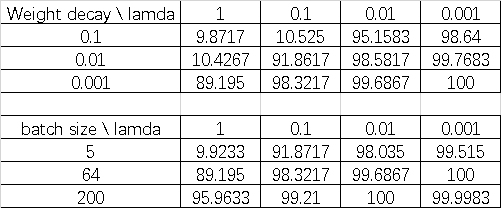

Q6. In my code, there is the class called torch.optim. I set the parameter "weight_decay" and it will automaticly do the regularization L2. 
It's the sum of the squares of each element in the weight function and then find the square root. It give penalty to weight parameter and bias parameter to decrease the possiblity of overfitting.

# Exercise 2

Q1. In the second exercise, I run the code in the local environment but I attach the code here and add the comment with the number of question to show you where I modify. In the Q1, I use matplotlib library to plot the data. The plot part is in the initialization part of class and in the end I initialize the class.

In [ ]:
from torchvision import transforms
from torch.utils.data import dataset, dataloader
from torchvision.datasets.folder import default_loader
from utils.RandomErasing import RandomErasing
from utils.RandomSampler import RandomSampler
from opt import opt
import os
import re
from matplotlib import pyplot as plt

class Data():
    def __init__(self):
        train_transform = transforms.Compose([
            transforms.Resize((384, 128), interpolation=3),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            RandomErasing(probability=0.5, mean=[0.0, 0.0, 0.0])
        ])

        test_transform = transforms.Compose([
            transforms.Resize((384, 128), interpolation=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.trainset = Market1501(train_transform, 'train', opt.data_path)
        self.testset = Market1501(test_transform, 'test', opt.data_path)
        self.queryset = Market1501(test_transform, 'query', opt.data_path)

        self.train_loader = dataloader.DataLoader(self.trainset,
                                                  sampler=RandomSampler(self.trainset, batch_id=opt.batchid,
                                                                        batch_image=opt.batchimage),
                                                  batch_size=opt.batchid * opt.batchimage, num_workers=8,
                                                  pin_memory=True)

        self.test_loader = dataloader.DataLoader(self.testset, batch_size=opt.batchtest, num_workers=8, pin_memory=True)
        self.query_loader = dataloader.DataLoader(self.queryset, batch_size=opt.batchtest, num_workers=8,
                                                  pin_memory=True)

        if opt.mode == 'vis':
            self.query_image = test_transform(default_loader(opt.query_image))

        #show image of Q1
        for i, data in enumerate(data_loader_train, 0):
          plt.imshow(data)
          plt.show()


class Market1501(dataset.Dataset):
    def __init__(self, transform, dtype, data_path):

        self.transform = transform
        self.loader = default_loader
        self.data_path = data_path

        if dtype == 'train':
            self.data_path += '/bounding_box_train'
        elif dtype == 'test':
            self.data_path += '/bounding_box_test'
        else:
            self.data_path += '/query'

        self.imgs = [path for path in self.list_pictures(self.data_path) if int(path.split('/')[-1].split('_')[0])  != -1]


        num_pids, num_imgs, num_cams,  = self.get_imagedata_info(self.imgs)
        print("Dataset statistics:")
        print("  ----------------------------------------")
        print("  subset   | # ids | # images | # cameras")
        print("  ----------------------------------------")
        print("  ", dtype ," |", str(num_pids) , "| ", str(num_imgs) ," | ", str(num_cams) )
        print("  ----------------------------------------")

        self.ids, self.cameras = self.get_id_cam()
        self.unique_ids=sorted(set(self.ids))

        self._id2label = {_id: idx for idx, _id in enumerate(self.unique_ids)} # Build a dictionary where the key is the id and the element is the label


    def __getitem__(self, index):
        # please write the __getitem__ method

        return img, target

    def __len__(self):
        # please write the __len__ method
        return 0

    def get_id_cam(self):
        """"
        :return: person id list and camera list corresponding to dataset image paths
        """
        return [int(file_path.split('/')[-1].split('_')[0]) for file_path in self.imgs], [int(file_path.split('/')[-1].split('_')[1][1]) for file_path in self.imgs]

    def get_id(self,file_path):
        """
        :param file_path: unix style file path
        :return: person id
        """
        return int(file_path.split('/')[-1].split('_')[0])

    def list_pictures(self,directory, ext='jpg|jpeg|bmp|png|ppm|npy'):
        assert os.path.isdir(directory), 'dataset does not exists!{}'.format(directory)

        return sorted([os.path.join(root, f)
                       for root, _, files in os.walk(directory) for f in files
                       if re.match(r'([\w]+\.(?:' + ext + '))', f)])

    def get_imagedata_info(self, data):
        pids, cams = [], []

        for file_path in data:
            camid = int(file_path.split('/')[-1].split('_')[1][1])
            pid=int(file_path.split('/')[-1].split('_')[0])
            pids += [pid]
            cams += [camid]
        pids = set(pids)
        cams = set(cams)
        num_pids = len(pids)
        num_cams = len(cams)
        num_imgs = len(data)
        return num_pids, num_imgs, num_cams

#initialize the class Q1
Net = Data()

Q2 To calculate the triplet loss, firstly I create the function to calculate the distance between two images. Then I use this function to calculate the distance between original image and two another similar images, one positive sample and another negative sample. At last the triplet loss is the sum of result in the second step. I found the code provided in the discord is better than what I wrote so I replace mine with the code in discord. 

In [ ]:
class TripletLoss(nn.Module):
    """Triplet loss with hard positive/negative mining.
        margin (float): margin for triplet.
    """

    def init(self, margin=0.3, mutual_flag=False):
        super(TripletLoss, self).init()
        self.margin = margin
        self.ranking_loss = nn.MarginRankingLoss(margin=margin)
        self.mutual = mutual_flag

    def forward(self, inputs, targets):
        """
        Args:
            inputs: feature matrix with shape (batch_size, feat_dim)
            targets: ground truth labels with shape (numclasses)
        """
        n = inputs.size(0)

        # Compute pairwise distance, replace by the official when merged
        dist = torch.pow(inputs, 2).sum(dim=1, keepdim=True).expand(n, n)
        dist = dist + dist.t()
        dist.addmm(1, -2, inputs, inputs.t())
        dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability
        # For each anchor, find the hardest positive and negative
        mask = targets.expand(n, n).eq(targets.expand(n, n).t())
        dist_ap, dist_an = [], []
        for i in range(n):
            dist_ap.append(dist[i][mask[i]].max().unsqueeze(0))
            dist_an.append(dist[i][mask[i] == 0].min().unsqueeze(0))
        dist_ap = torch.cat(dist_ap)
        dist_an = torch.cat(dist_an)
        # Compute ranking hinge loss
        y = torch.ones_like(dist_an)
        loss = self.ranking_loss(dist_an, dist_ap, y)
        if self.mutual:
            return loss, dist
        return loss

Q3 In the RandomSampler.py, there are two classes RandomSampler and RandomIdentitySampler. In the first class, il chooses randomly the image with its id. In the second class, it chooses the indice randomly. Moreover, they both have the len function, which tell us the length of sample. Besides, the class RandomSampler has a static function to enhance the population if it's too small.